In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth',None)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Importing data

In [3]:
df_deals_raw = pd.read_excel('../raw_data/deals_raw.xlsx')

# Preprocessing

In [4]:
rel_columns = ['target_name', 'name', 'target_ebit', 'target_ebitda', 'target_revenue']

dict_2 = {}
dict_3 = {}
dict_4 = {}


#'name_de.2', 'name_de.3', 'name_de.4

for i in df_deals_raw['target_name'].unique():
    df_rel = df_deals_raw.loc[df_deals_raw['target_name'] == i]
    set_rel_2 = set(df_rel['name_de.2'])
    dict_2[i] = set_rel_2

    set_rel_3 = set(df_rel['name_de.3'])
    dict_3[i] = set_rel_3

    set_rel_4 = set(df_rel['name_de.4'])
    dict_4[i] = set_rel_4

In [5]:
df_deals_raw_rel = df_deals_raw[rel_columns].copy().drop_duplicates(subset = 'name')

In [6]:
df_deals_raw_rel['2'] = df_deals_raw_rel.target_name.apply(lambda x: dict_2.get(x))
df_deals_raw_rel['3'] = df_deals_raw_rel.target_name.apply(lambda x: dict_3.get(x))
df_deals_raw_rel['4'] = df_deals_raw_rel.target_name.apply(lambda x: dict_4.get(x))

In [7]:
df_deals_raw_rel['comb'] = df_deals_raw_rel.apply(lambda x: set.union(x['2'], x['3'], x['4']), axis = 1)
df_deals_raw_rel['comb_str'] = df_deals_raw_rel.comb.apply(lambda x: list(map(str, x)))
df_deals_raw_rel['strs'] = df_deals_raw_rel.comb_str.apply(lambda x:  ",".join(list(x)))

In [12]:
df_deals_raw_rel.drop_duplicates(subset='target_name', keep="first",inplace=True)

In [15]:
df_deals_raw_rel.head()

,target_name,name,target_ebit,target_ebitda,target_revenue,2,3,4,comb,comb_str,strs
0,Sun [Target],1301 Sun,NaN,NaN,NaN,{Energie},{Solarenergie},"{energie, solar, pv, photovoltaik}","{energie, Solarenergie, pv, photovoltaik, Ener...","[energie, Solarenergie, pv, photovoltaik, Ener...","energie,Solarenergie,pv,photovoltaik,Energie,s..."
4,Supple [Target],1220 Supple,NaN,NaN,57.70,{Energie},"{Erneuerbare Energie - sonstige, Solarenergie}","{sonne, solar, energie, pv, photovoltaik, fres...","{Solarenergie, sonne, solar, Erneuerbare Energ...","[Solarenergie, sonne, solar, Erneuerbare Energ...","Solarenergie,sonne,solar,Erneuerbare Energie -..."
16,SPH Sustainable Process Heat GmbH,1677 Heat,-0.78,-0.78,0.43,{Industrielle Produkte & Dienstleistungen},{Pumpen und Armaturen},"{energieeffizient, wärmepumpentechnologie, pum...","{energieeffizient, Industrielle Produkte & Die...","[energieeffizient, Industrielle Produkte & Die...","energieeffizient,Industrielle Produkte & Diens..."
22,SUMMIQ AG,845 Apollo,0.00,0.00,0.00,{Finanzdienstleistungen},{Finanzdienstleistungen - sonstige},"{stadtwerkegruppen, stadtwerke, infrastrukturf...","{stadtwerkegruppen, energieversorger, stadtwer...","[stadtwerkegruppen, energieversorger, stadtwer...","stadtwerkegruppen,energieversorger,stadtwerke,..."
26,KSW Bioenergie GmbH,390 Saragossa,0.00,0.00,0.00,{Energie},{Bioenergie},"{kraftwerk, erneuerbare energie, biotreibstoff...","{kraftwerk, erneuerbare energie, biotreibstoff...","[kraftwerk, erneuerbare energie, biotreibstoff...","kraftwerk,erneuerbare energie,biotreibstoff,bi..."


In [90]:
# df[1].fillna(0, inplace=True)
df_deals_raw_work = df_deals_raw_rel[['target_name','target_ebit','target_revenue','strs']]

In [91]:
import string 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text


df_deals_raw_work.dropna(subset='target_name',inplace=True)
#df_deals_raw_work.reset_index().drop('index',axis=1)
df_deals_raw_work['strs'] = df_deals_raw_work['strs'].str.replace(',',' ')
df_deals_raw_work[['target_ebit','target_revenue']] = df_deals_raw_work[['target_ebit','target_revenue']].replace(np.nan, 0)
df_deals_raw_work.reset_index().drop('index',axis=1)

df_deals_raw_work['strs'] = df_deals_raw_work['strs'].apply(remove_punctuations) 
df_deals_raw_work['strs'] = df_deals_raw_work['strs'].apply(lambda x: x.lower())

stop_words = set(stopwords.words('german')) 

for name_de in df_deals_raw_work['strs']:    
    word_tokens = word_tokenize(name_de) 
    name_de = [w for w in word_tokens if not w in stop_words] 

/tmp/ipykernel_1395/3600791807.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deals_raw_work.dropna(subset='target_name',inplace=True)
/tmp/ipykernel_1395/3600791807.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deals_raw_work['strs'] = df_deals_raw_work['strs'].str.replace(',',' ')
/tmp/ipykernel_1395/3600791807.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [92]:
df_deals_raw_work.columns[0:]

Index(['target_name', 'target_ebit', 'target_revenue', 'strs'], dtype='object')

In [93]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [120]:
df_deals_raw_work_fin = pd.DataFrame(scaler.fit_transform(
                        df_deals_raw_work.drop(columns=['target_name','strs'])),
                                    columns=['target_ebit', 'target_revenue'])
df_deals_raw_work_fin = df_deals_raw_work_fin.reset_index().drop('index',axis=1)
df_deals_raw_work_fin

,target_ebit,target_revenue
0,0.617200,0.000140
1,0.617200,0.028986
2,0.607248,0.000355
3,0.617200,0.000140
4,0.617200,0.000140
5,0.693760,0.030136
6,0.641444,0.002890
7,0.663136,0.031286
8,0.632512,0.003390
9,0.629960,0.002140


In [115]:
df_deals_raw_work = df_deals_raw_work.reset_index().drop('index',axis=1)

In [125]:
df_deals_raw_work1 = pd.concat([df_deals_raw_work.drop(columns=['target_ebit','target_revenue']), df_deals_raw_work_fin], axis=1)
#.reset_index().drop('index',axis=1)
df_deals_raw_work1.shape

(1084, 4)

In [126]:
vec_tf_target = TfidfVectorizer()
x_tf_target = vec_tf_target.fit_transform(df_deals_raw_work1['strs'])
df_wrds_tf_target = pd.DataFrame(x_tf_target.toarray(), columns=vec_tf_target.get_feature_names_out())
df_tf_target = pd.concat([df_deals_raw_work1, df_wrds_tf_target], axis=1)
df_tf_target.drop('strs', axis=1, inplace=True)
df_tf_target_4pca = df_tf_target.drop('target_name',axis=1)

In [127]:
df_tf_target_4pca.head()

target_ebit  target_revenue   3d  3ddruck   40  4942005  abbruch  \
0     0.617200        0.000140  0.0      0.0  0.0      0.0      0.0   
1     0.617200        0.028986  0.0      0.0  0.0      0.0      0.0   
2     0.607248        0.000355  0.0      0.0  0.0      0.0      0.0   
3     0.617200        0.000140  0.0      0.0  0.0      0.0      0.0   
4     0.617200        0.000140  0.0      0.0  0.0      0.0      0.0   

   abbrucharbeiten  abdeckpapierrollen  abdeckscheibe  abdeckungen  \
0              0.0                 0.0            0.0          0.0   
1              0.0                 0.0            0.0          0.0   
2              0.0                 0.0            0.0          0.0   
3              0.0                 0.0            0.0          0.0   
4              0.0                 0.0            0.0          0.0   

   abdichtung  abdichtungen  abfall  abfluss  abfüll  abfüller  abfüllung  \
0         0.0           0.0     0.0      0.0     0.0       0.0        0.0   
1         0.0           0.0     0.0      0.0     0.0       0.0        0.0   
2         0.0           0.0     0.0      0.0     0.0       0.0        0.0   
3         0.0           0.0     0.0      0.0     0.0       0.0        0.0   
4         0.0           0.0     0.0      0.0     0.0       0.0        0.0   

   abgas  abgasanlage  abgasreinigung  abgassystem  abkanten  \
0    0.0          0.0             0.0          0.0       0.0   
1    0.0          0.0             0.0          0.0       0.0   
2    0.0          0.0             0.0          0.0       0.0   
3    0.0          0.0             0.0          0.0       0.0   
4    0.0          0.0             0.0          0.0       0.0   

   ablauforganisation  abluft  abluftreinigung  abluftwäscher  abrechnung  \
0                 0.0     0.0              0.0            0.0         0.0   
1                 0.0     0.0              0.0            0.0         0.0   
2                 0.0     0.0              0.0            0.0         0.0   
3                 0.0     0.0              0.0            0.0         0.0   
4                 0.0     0.0              0.0            0.0         0.0   

   abrechnungsdienstleister  abrechnungsdienstleistung  abriss  \
0                       0.0                        0.0     0.0   
1                       0.0                        0.0     0.0   
2                       0.0                        0.0     0.0   
3                       0.0                        0.0     0.0   
4                       0.0                        0.0     0.0   

   absatzlogistik  absaug  absaugsystem  absorption  absperrklappen  \
0             0.0     0.0           0.0         0.0             0.0   
1             0.0     0.0           0.0         0.0             0.0   
2             0.0     0.0           0.0         0.0             0.0   
3             0.0     0.0           0.0         0.0             0.0   
4             0.0     0.0           0.0         0.0             0.0   

   absperrventile  abwasser  abwassertechnik  abwasserunternehmen   abwärme  \
0             0.0       0.0              0.0                  0.0  0.000000   
1             0.0       0.0              0.0                  0.0  0.000000   
2             0.0       0.0              0.0                  0.0  0.336632   
3             0.0       0.0              0.0                  0.0  0.000000   
4             0.0       0.0              0.0                  0.0  0.000000   

   access  accessoire  accessoires  acmi  administrativen  ads  \
0     0.0         0.0          0.0   0.0              0.0  0.0   
1     0.0         0.0          0.0   0.0              0.0  0.0   
2     0.0         0.0          0.0   0.0              0.0  0.0   
3     0.0         0.0          0.0   0.0              0.0  0.0   
4     0.0         0.0          0.0   0.0              0.0  0.0   

   adventskalendar  adventskalender  advertise  advertiser  adwords  aed  \
0              0.0              0.0        0.0         0.0      0.0  0.0

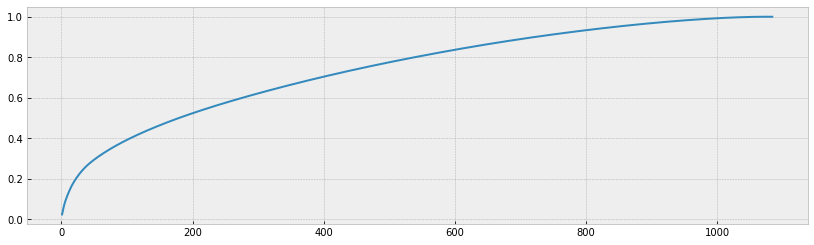

Number features: 843
Total Variance Explained: 0.9501242792026331
0.9475228648192046


In [128]:
pca_tf_target = PCA()
df_tf_target_pca = pca_tf_target.fit_transform(df_tf_target_4pca)
plt.style.use("bmh")
plt.figure(figsize=(14,4))
plt.plot(range(1,df_tf_target_pca.shape[1]+1), pca_tf_target.explained_variance_ratio_.cumsum())
plt.show()
total_explained_variance = pca_tf_target.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance>=.95])
n_to_reach_95 = df_tf_target_pca.shape[1] - n_over_95
print(f"Number features: {n_to_reach_95}\nTotal Variance Explained: {total_explained_variance[n_to_reach_95]}")

# Reducing the dataset to the number of features determined before
pca_tf_target = PCA(n_components=n_to_reach_95)

# Fitting and transforming the dataset to the stated number of features and creating a new DF
df_tf_target_pca = pca_tf_target.fit_transform(df_tf_target_4pca)

# Seeing the variance ratio that still remains after the dataset has been reduced
print(pca_tf_target.explained_variance_ratio_.cumsum()[-1])

In [129]:
nn_target_tf_pca = NearestNeighbors(n_neighbors=10).fit(df_tf_target_pca)

In [130]:
df_deals_raw_work1

,target_name,strs,target_ebit,target_revenue
0,Sun [Target],energie solarenergie pv photovoltaik energie s...,0.617200,0.000140
1,Supple [Target],solarenergie sonne solar erneuerbare energie ...,0.617200,0.028986
2,SPH Sustainable Process Heat GmbH,energieeffizient industrielle produkte dienst...,0.607248,0.000355
3,SUMMIQ AG,stadtwerkegruppen energieversorger stadtwerke ...,0.617200,0.000140
4,KSW Bioenergie GmbH,kraftwerk erneuerbare energie biotreibstoff bi...,0.617200,0.000140
5,Blast [Target],industrielle produkte dienstleistungen oberfl...,0.693760,0.030136
6,CBW College Berufliche Weiterbildung GmbH,weiterbildung experte sprachen itschulung bild...,0.641444,0.002890
7,J.S. Logistik GmbH,logistik transport importeure und großhändler ...,0.663136,0.031286
8,DOLI Elektronik GmbH,industrielle mess und sensortechnik kontrollko...,0.632512,0.003390
9,KST Kranservice & Technik GmbH,industrielle produkte dienstleistungen indust...,0.629960,0.002140


In [133]:
target_pred = df_deals_raw_work1[df_deals_raw_work1['target_name']=='Maybach-Luxury']
target_pred

,target_name,strs,target_ebit,target_revenue
75,Maybach-Luxury,brille lizenz eyewear augen accessoire luxus k...,0.622304,0.00314


In [148]:
target_pred_scapled = pd.DataFrame(scaler.transform(target_pred.drop(columns=['target_name','strs'])),
                                  columns=['target_ebit', 'target_revenue'])

tx_to_pred = vec_tf_target.transform(target_pred['strs'])
df_target_pred_wrds = pd.DataFrame(tx_to_pred.toarray(),columns=vec_tf_target.get_feature_names_out())
#df_target_pred = pd.concat([target_pred,df_target_pred_wrds], axis=1)
df_target_pred = df_target_pred_wrds.copy()
df_target_pred.insert(0,'target_ebit',target_pred_scapled['target_ebit'])
df_target_pred.insert(1,'target_revenue',target_pred_scapled['target_revenue'])
#df_target_pred.drop('strs', axis=1, inplace=True)
#df_target_pred_4pca = df_target_pred.drop('target_name',axis=1)
#.dropna()
#df_target_pred_4pca
#df_target_pred_pca = pca_tf_target.transform(df_target_pred_4pca)
df_target_pred_pca = pca_tf_target.transform(df_target_pred)

In [147]:
df_target_pred

target_ebit  target_revenue   3d  3ddruck   40  4942005  abbruch  \
0     0.625141        0.000142  0.0      0.0  0.0      0.0      0.0   

   abbrucharbeiten  abdeckpapierrollen  abdeckscheibe  abdeckungen  \
0              0.0                 0.0            0.0          0.0   

   abdichtung  abdichtungen  abfall  abfluss  abfüll  abfüller  abfüllung  \
0         0.0           0.0     0.0      0.0     0.0       0.0        0.0   

   abgas  abgasanlage  abgasreinigung  abgassystem  abkanten  \
0    0.0          0.0             0.0          0.0       0.0   

   ablauforganisation  abluft  abluftreinigung  abluftwäscher  abrechnung  \
0                 0.0     0.0              0.0            0.0         0.0   

   abrechnungsdienstleister  abrechnungsdienstleistung  abriss  \
0                       0.0                        0.0     0.0   

   absatzlogistik  absaug  absaugsystem  absorption  absperrklappen  \
0             0.0     0.0           0.0         0.0             0.0   

   absperrventile  abwasser  abwassertechnik  abwasserunternehmen  abwärme  \
0             0.0       0.0              0.0                  0.0      0.0   

   access  accessoire  accessoires  acmi  administrativen  ads  \
0     0.0     0.34581          0.0   0.0              0.0  0.0   

   adventskalendar  adventskalender  advertise  advertiser  adwords  aed  \
0              0.0              0.0        0.0         0.0      0.0  0.0   

   aerospace  affiliate  affiliatemarketing  agency  agentur  aggregate  \
0        0.0        0.0                 0.0     0.0      0.0        0.0   

   agile  agiles  agra  agrar  agrartechnik  agri  agribusinessberatung  \
0    0.0     0.0   0.0    0.0           0.0   0.0                   0.0   

   agricultural  agro   ai  air  airbagbefestigungen  aircraft  airline  \
0           0.0   0.0  0.0  0.0                  0.0       0.0      0.0   

   akadamie  akadem  akademie  akkuschrauber  aktenvernichtung  \
0       0.0     0.0       0.0            0.0               0.0   

   aktenverwaltung  aktions  akustik  alarm  alarmanlagen  alarmdienste  \
0              0.0      0.0      0.0    0.0           0.0           0.0   

   algen  algorithmus  alkoholfreie  alkoholisch  alle  alleinarbeiten  aller  \
0    0.0          0.0           0.0          0.0   0.0             0.0    0.0   

   altenheim  altenpflege  alternative  altersbedingte  altersheim  altgerät  \
0        0.0          0.0          0.0             0.0         0.0       0.0   

   altlasten  alu  aludruckguss  aluminium  aluminiumgussteile  \
0        0.0  0.0           0.0        0.0                 0.0   

   aluminiumproduktion  aluminiumprofile  aluminum  aluproduktion  amazon  \
0                  0.0               0.0       0.0            0.0     0.0   

   ambulan  ambulant  ambulante  ambulanter  ambulantes  amphibische  \
0      0.0       0.0        0.0         0.0         0.0          0.0   

   amplifiers  analysegerät  analysegeräte  analysis  analytics  analytische  \
0         0.0           0.0            0.0       0.0        0.0          0.0   

   anbieter  and  andere  angels  angussteile  animal  animation  \
0       0.0  0.0     0.0     0.0          0.0     0.0        0.0   

   animationsinhalten  anlage  anlagebau  anlagen  anlagenbau  \
0                 0.0     0.0        0.0      0.0         0.0   

   anlagenbetriebssicherheit  anlagenkomponenten  anlagentechnik  \
0                        0.0                 0.0             0.0   

   anlaufscheibem  anschlusssysteme  antennen  antennentechnik  antiageing  \
0             0.0               0.0       0.0              0.0         0.0   

   antikoagulanzien  antragssoftware  antrieb  antriebe  antriebs  \
0               0.0              0.0      0.0       0.0       0.0   

   antriebssystem  antriebssysteme  antriebstechnik  antriebsys  \
0             0.0              0.0              0.0         0.0   

   anwendungsentwicklung  anwendungssoftware  anzug  anästesie  anästh

In [150]:
nn_target_tf_pca = NearestNeighbors(n_neighbors=10).fit(df_tf_target_pca)
nn_targets = nn_target_tf_pca.kneighbors(df_target_pred_pca,10)

In [151]:
for x,y in zip(nn_targets[1][0],nn_targets[0][0]):
    print(f"{df_deals_raw_work1['target_name'].iloc[x]}")
    print(f"{df_deals_raw_work1['strs'].iloc[x]}")
    print(f"distance {y}")
    print('+++++++++++++++++++++++++++++++++++++++++++++')

Maybach-Luxury
brille lizenz eyewear augen accessoire luxus konsumgüter  bekleidung konsumgüter luxusgüter
distance 0.002798027717121883
+++++++++++++++++++++++++++++++++++++++++++++
Habermann International Brands GmbH
bekleidung accessoires bekleidung mode konsumgüter  bekleidung konsumgüter handel textil
distance 1.1132153888739467
+++++++++++++++++++++++++++++++++++++++++++++
Goldkontor Hamburg GmbH
handel gold konsumgüter  bekleidung luxusgüter handel  sonstige handel
distance 1.1206943832766068
+++++++++++++++++++++++++++++++++++++++++++++
CECILE FESTMODENCENTRUM GMBH & CO. KG
brautkleid handel fashion bekleidung einzelhandel bekleidung bekleidung mode konsumgüter  bekleidung festmode luxusgüter hochzeitskleidung
distance 1.132215696232231
+++++++++++++++++++++++++++++++++++++++++++++
Epona [Target]
händler fahrrad konsumgüter  bekleidung luxusgüter ebike
distance 1.132663194223857
+++++++++++++++++++++++++++++++++++++++++++++
UNITRONIC Elektronische Steuergeräte GmbH
physiotherap

In [160]:
name = []
description = []
distance = []



for x,y in zip(nn_targets[1][0],nn_targets[0][0]):
    name.append(df_deals_raw_work1['target_name'].iloc[x])
    description.append(df_deals_raw_work1['strs'].iloc[x])
    distance.append(y)
    
    
df_companies = pd.DataFrame({'name':name,
               'description':description,
               'distance':distance})

In [163]:
df_companies

,name,description,distance
0,Maybach-Luxury,brille lizenz eyewear augen accessoire luxus konsumgüter bekleidung konsumgüter luxusgüter,0.002798
1,Habermann International Brands GmbH,bekleidung accessoires bekleidung mode konsumgüter bekleidung konsumgüter handel textil,1.113215
2,Goldkontor Hamburg GmbH,handel gold konsumgüter bekleidung luxusgüter handel sonstige handel,1.120694
3,CECILE FESTMODENCENTRUM GMBH & CO. KG,brautkleid handel fashion bekleidung einzelhandel bekleidung bekleidung mode konsumgüter bekleidung festmode luxusgüter hochzeitskleidung,1.132216
4,Epona [Target],händler fahrrad konsumgüter bekleidung luxusgüter ebike,1.132663
5,UNITRONIC Elektronische Steuergeräte GmbH,physiotherapie körperpflege pflege kosmetik körperpflege fußpflege wellness nagepflege konsumgüter bekleidung konsumgüter luxusgüter freizeit produkte luxusgüter,1.156090
6,LEADER LTD,pedelec bike fahrrad konsumgüter bekleidung luxusgüter freizeit produkte ebike,1.175454
7,Laurèl GmbH,label fashion retail bekleidung luxus konsumgüter bekleidung mode damenbekleidung handel shop,1.178840
8,CrystalClearAir OG,bergluft kosmetikprodukt körperpflege handel sonstige erfrischer handel luxus sprühdose konsumgüter bekleidung luxusgüter lifestyle inkl sport musik bücher,1.178961
9,LC272301 Consumer [Target],modeaccessoires bekleidung konsumgüter bekleidung design luxusgüter uhr schmuck,1.181517


In [164]:
matching_table = pd.read_excel('../raw_data/matching_table.xlsx')

In [165]:
matching_table.head()



,Unnamed: 0,id,project_name,target_id,target_name,investor_id,comp_name,deal_stage_id,is_lost,target_description,target_revenue,target_ebitda,target_ebit,target_region_id,keywords_y
0,0,32980,1923 Creativ,10309.0,cm.supplies GmbH,2508,MKCP Beteiligungsgesellschaft mbH,4,1,Fachmärkte für Bürobedarf und Kreativprodukte,4.0,0.2,NaN,2.0,"konsumgüter, handel, spielzeug, bürobedarf, geschenke, discount, schulbedarf, kreativprodukte"
1,8,34787,1923 Creativ,10309.0,cm.supplies GmbH,2726,Axos MidCap GmbH-Triginta Capital GmbH,4,1,Fachmärkte für Bürobedarf und Kreativprodukte,4.0,0.2,NaN,2.0,"konsumgüter, handel, spielzeug, bürobedarf, geschenke, discount, schulbedarf, kreativprodukte"
2,16,32257,1923 Creativ,10309.0,cm.supplies GmbH,2050,COREST GmbH,2,0,Fachmärkte für Bürobedarf und Kreativprodukte,4.0,0.2,NaN,2.0,"konsumgüter, handel, spielzeug, bürobedarf, geschenke, discount, schulbedarf, kreativprodukte"
3,24,29699,1923 Creativ,10309.0,cm.supplies GmbH,2597,KAUT-BULLINGER Office + Solution GmbH,2,0,Fachmärkte für Bürobedarf und Kreativprodukte,4.0,0.2,NaN,2.0,"konsumgüter, handel, spielzeug, bürobedarf, geschenke, discount, schulbedarf, kreativprodukte"
4,32,30467,1923 Creativ,10309.0,cm.supplies GmbH,3913,Printus Family Office,2,1,Fachmärkte für Bürobedarf und Kreativprodukte,4.0,0.2,NaN,2.0,"konsumgüter, handel, spielzeug, bürobedarf, geschenke, discount, schulbedarf, kreativprodukte"


In [166]:
matching_table[matching_table['target_name']=='Maybach-Luxury']

,Unnamed: 0,id,project_name,target_id,target_name,investor_id,comp_name,deal_stage_id,is_lost,target_description,target_revenue,target_ebitda,target_ebit,target_region_id,keywords_y
29869,212530,20098,876 Berlin,97.0,Maybach-Luxury,4223,Eso Capital UK Ltd,4,1,"MAYBACH ICONS specializes in German hand-crafted luxury goods, with each piece embodying our timeless heritage of design, precision, and excellence.",6.0,0.4,0.4,7.0,"konsumgüter, lizenz, accessoire, brille, eyewear, luxus, augen"
29870,212537,13313,876 Berlin,97.0,Maybach-Luxury,2606,Abacus Alpha GmbH,2,0,"MAYBACH ICONS specializes in German hand-crafted luxury goods, with each piece embodying our timeless heritage of design, precision, and excellence.",6.0,0.4,0.4,7.0,"konsumgüter, lizenz, accessoire, brille, eyewear, luxus, augen"
29871,212544,3074,876 Berlin,97.0,Maybach-Luxury,1785,Liesner & Co. GmbH,2,1,"MAYBACH ICONS specializes in German hand-crafted luxury goods, with each piece embodying our timeless heritage of design, precision, and excellence.",6.0,0.4,0.4,7.0,"konsumgüter, lizenz, accessoire, brille, eyewear, luxus, augen"
29872,212551,20482,876 Berlin,97.0,Maybach-Luxury,4495,Perpetua Holding GmbH,2,1,"MAYBACH ICONS specializes in German hand-crafted luxury goods, with each piece embodying our timeless heritage of design, precision, and excellence.",6.0,0.4,0.4,7.0,"konsumgüter, lizenz, accessoire, brille, eyewear, luxus, augen"
29873,212558,1542,876 Berlin,97.0,Maybach-Luxury,942,Investindustrial Holdings SA - BI-Invest Advisors SA,2,0,"MAYBACH ICONS specializes in German hand-crafted luxury goods, with each piece embodying our timeless heritage of design, precision, and excellence.",6.0,0.4,0.4,7.0,"konsumgüter, lizenz, accessoire, brille, eyewear, luxus, augen"
29874,212565,3082,876 Berlin,97.0,Maybach-Luxury,1787,Tresono Family Office,2,1,"MAYBACH ICONS specializes in German hand-crafted luxury goods, with each piece embodying our timeless heritage of design, precision, and excellence.",6.0,0.4,0.4,7.0,"konsumgüter, lizenz, accessoire, brille, eyewear, luxus, augen"
29875,212572,19982,876 Berlin,97.0,Maybach-Luxury,4079,Upside Equity Advisory GmbH,2,1,"MAYBACH ICONS specializes in German hand-crafted luxury goods, with each piece embodying our timeless heritage of design, precision, and excellence.",6.0,0.4,0.4,7.0,"konsumgüter, lizenz, accessoire, brille, eyewear, luxus, augen"
29876,212579,18967,876 Berlin,97.0,Maybach-Luxury,3633,HAL Investments BV,2,0,"MAYBACH ICONS specializes in German hand-crafted luxury goods, with each piece embodying our timeless heritage of design, precision, and excellence.",6.0,0.4,0.4,7.0,"konsumgüter, lizenz, accessoire, brille, eyewear, luxus, augen"
29877,212586,7450,876 Berlin,97.0,Maybach-Luxury,2296,NGC Nachfolgekapital GmbH,2,1,"MAYBACH ICONS specializes in German hand-crafted luxury goods, with each piece embodying our timeless heritage of design, precision, and excellence.",6.0,0.4,0.4,7.0,"konsumgüter, lizenz, accessoire, brille, eyewear, luxus, augen"
29878,212593,23067,876 Berlin,97.0,Maybach-Luxury,5766,COFRA Holding AG / Anthos Asset Management,2,0,"MAYBACH ICONS specializes in German hand-crafted luxury goods, with each piece embodying our timeless heritage of design, precision, and excellence.",6.0,0.4,0.4,7.0,"konsumgüter, lizenz, accessoire, brille, eyewear, luxus, augen"


In [222]:
matching_investors = []
matching_target = []
matching_distance = []
for company in df_companies['name']:
    next_investor = matching_table[matching_table['target_name']==company]['comp_name'].tolist()
    matching_investors+=next_investor
    matching_target+=len(next_investor)*[company]
    next_distance = df_companies[df_companies['name']==company]['distance'].tolist()
    matching_distance+=len(next_investor)*next_distance
#matching_investors_unique = list(set(matching_investors))
df_match_investors = pd.DataFrame({'investors':matching_investors,'targets':matching_target,'distance':matching_distance})

In [226]:
df_match_investors

,investors,targets,distance
0,Eso Capital UK Ltd,Maybach-Luxury,0.002798
1,Abacus Alpha GmbH,Maybach-Luxury,0.002798
2,Liesner & Co. GmbH,Maybach-Luxury,0.002798
3,Perpetua Holding GmbH,Maybach-Luxury,0.002798
4,Investindustrial Holdings SA - BI-Invest Advisors SA,Maybach-Luxury,0.002798
5,Tresono Family Office,Maybach-Luxury,0.002798
6,Upside Equity Advisory GmbH,Maybach-Luxury,0.002798
7,HAL Investments BV,Maybach-Luxury,0.002798
8,NGC Nachfolgekapital GmbH,Maybach-Luxury,0.002798
9,COFRA Holding AG / Anthos Asset Management,Maybach-Luxury,0.002798


In [243]:
if len(df_match_investors['investors'].unique())>=10:
    best_investors = df_match_investors['investors'].unique()[:10].tolist()
else:
    best_investors = df_match_investors['investors'].unique().tolist()

In [286]:
df_match_investors[df_match_investors['investors']=='HAP INDUSTRIE INVEST GMBH']['distance'].min()

0.002798027717121883

In [244]:
best_investors

['Eso Capital UK Ltd',
 'Abacus Alpha GmbH',
 'Liesner & Co. GmbH',
 'Perpetua Holding GmbH',
 'Investindustrial Holdings SA - BI-Invest Advisors SA',
 'Tresono Family Office',
 'Upside Equity Advisory GmbH',
 'HAL Investments BV',
 'NGC Nachfolgekapital GmbH',
 'COFRA Holding AG / Anthos Asset Management']

# INVESTORS PART

In [245]:
key_match = pd.read_excel('../raw_data/new_keywords.xlsx')
invest_key = pd.read_excel('../raw_data/invest_profile_keywords.xlsx')

In [249]:
invest_key['name_de'] = invest_key['name_de'].replace(dict(zip(key_match.name_de,key_match.new_keyword)))
invest_key_small = invest_key[['name','name_de']]
invest_key_concat = invest_key_small.astype(str).groupby('name').agg({'name_de':', '.join})
    
invest_key_concat1 = invest_key_concat['name_de'].str.replace('nan','').reset_index()
invest_key_concat1['name_de'] = invest_key_concat1['name_de'].apply(remove_punctuations)        
invest_key_concat1['name_de'].replace(r'^\s*$',np.nan,regex=True,inplace=True)
invest_key_concat1 = invest_key_concat1.dropna().reset_index().drop('index',axis=1)
invest_key_concat1['name_de'] = invest_key_concat1['name_de'].apply(lambda x: x.lower())

stop_words = set(stopwords.words('german')) 

for name_de in invest_key_concat1['name_de']:    
    word_tokens = word_tokenize(name_de) 
    name_de = [w for w in word_tokens if not w in stop_words] 

In [250]:
vec_tf_key = TfidfVectorizer()
x_tf_key = vec_tf_key.fit_transform(invest_key_concat1['name_de'])
df_wrds_tf_key = pd.DataFrame(x_tf_key.toarray(), columns=vec_tf_key.get_feature_names_out())
df_tf_key = pd.concat([invest_key_concat1, df_wrds_tf_key], axis=1)
df_tf_key.drop('name_de', axis=1, inplace=True)
df_tf_key_4pca = df_tf_key.drop('name',axis=1)

In [251]:
pca_tf_key = PCA()
df_tf_key_pca = pca_tf_key.fit_transform(df_tf_key_4pca)
#plt.style.use("bmh")
#plt.figure(figsize=(14,4))
#plt.plot(range(1,df_tf_key_pca.shape[1]+1), pca_tf_key.explained_variance_ratio_.cumsum())
#plt.show()
total_explained_variance = pca_tf_key.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance>=.95])
n_to_reach_95 = df_tf_key_pca.shape[1] - n_over_95
#print(f"Number features: {n_to_reach_95}\nTotal Variance Explained: {total_explained_variance[n_to_reach_95]}")

# Reducing the dataset to the number of features determined before
pca_tf_key = PCA(n_components=n_to_reach_95)

# Fitting and transforming the dataset to the stated number of features and creating a new DF
df_tf_key_pca = pca_tf_key.fit_transform(df_tf_key_4pca)

# Seeing the variance ratio that still remains after the dataset has been reduced
#print(pca_tf_key.explained_variance_ratio_.cumsum()[-1])

In [287]:
qty_of_nn = 5
nn_key_tf_pca = NearestNeighbors(n_neighbors=qty_of_nn).fit(df_tf_key_pca)

In [281]:
best_investors

['Eso Capital UK Ltd',
 'Abacus Alpha GmbH',
 'Liesner & Co. GmbH',
 'Perpetua Holding GmbH',
 'Investindustrial Holdings SA - BI-Invest Advisors SA',
 'Tresono Family Office',
 'Upside Equity Advisory GmbH',
 'HAL Investments BV',
 'NGC Nachfolgekapital GmbH',
 'COFRA Holding AG / Anthos Asset Management']

In [314]:
invest_key_concat1[invest_key_concat1['name']=='Eso Capital UK Ltd']['name_de'].to_list()[0]

'zubehör glas handel luxusgüter lizenz sme fizierung'

In [318]:
for investor in best_investors:
    name_investor.append(investor)
    if invest_key_concat1['name'].str.contains(investor).any():
        description_investor.append(invest_key_concat1[invest_key_concat1['name']==investor]['name_de'].to_list()[0])
    else:
        description_investor.append('Investor not in the list')
    distance_investor_investor.append(0)
    distance_target_target.append(df_match_investors[df_match_investors['investors']==investor]['distance'].min())

In [320]:
len(description_investor), len(name_investor), len(distance_investor_investor)

(282, 283, 282)

In [321]:
lala = []
lala.append('pawel')
lala

['pawel']

In [324]:
#to_pred = invest_key_concat1[invest_key_concat1['name'].isin(best_investors)]

name_investor = []
description_investor = []
distance_investor_investor = []
distance_target_target = []


for investor in best_investors:
    name_investor.append(investor)
    if invest_key_concat1['name'].str.contains(investor).any():
        description_investor.append(invest_key_concat1[invest_key_concat1['name']==investor]['name_de'].to_list()[0])
    else:
        description_investor.append('Investor not in the list')
    distance_investor_investor.append(0)
    distance_target_target.append(df_match_investors[df_match_investors['investors']==investor]['distance'].min())



for investor in best_investors:
    if invest_key_concat1['name'].str.contains(investor).any():
        first_distance = df_match_investors[df_match_investors['investors']==investor]['distance'].min()
        to_pred = invest_key_concat1[invest_key_concat1['name']==investor]
        x_to_pred = vec_tf_key.transform(to_pred['name_de'])
        df_pred_wrds = pd.DataFrame(x_to_pred.toarray(),columns=vec_tf_key.get_feature_names_out())
        df_pred = pd.concat([to_pred,df_pred_wrds], axis=1)
        df_pred.drop('name_de', axis=1, inplace=True)
        df_pred_4pca = df_pred.drop('name',axis=1).dropna()
        df_pred_pca = pca_tf_key.transform(df_pred_4pca)

        nn_investors = nn_key_tf_pca.kneighbors(df_pred_pca)


        for x,y in zip(nn_investors[1][0],nn_investors[0][0]):
            name_investor.append(invest_key_concat1['name'].iloc[x])
            description_investor.append(invest_key_concat1['name_de'].iloc[x])
            distance_investor_investor.append(y)
            distance_target_target.append(first_distance)
        
df_investors = pd.DataFrame({'name':name_investor,
               'description':description_investor,
               'distance_investor<=>investor':distance_investor_investor,
                'distance_target<=>target':distance_target_target,
                'distance_target=<>investor': [a+b for a,b in zip(distance_investor_investor,distance_target_target)]})

df_investors_sorted = df_investors.sort_values('distance_target=<>investor')

In [327]:
df_investors_sorted

,name,description,distance_investor<=>investor,distance_target<=>target,distance_target=<>investor
0,Eso Capital UK Ltd,zubehör glas handel luxusgüter lizenz sme fizierung,0.000000,0.002798,0.002798
1,Abacus Alpha GmbH,energie nachhaltig personaldienstleister maschinenbau recycling marketing automatisierung b2b industrie ingenieur personaldienstleister training automatisierung energie ausbaudienst video vermittlung personaldienstleister beratung fertigung wasseraufbereitung reinigung aufbereitung werkstoffe abwasser ressourcen produktion industrie technologie digitalisierung industrie armaturentechnik druck fertigung headhunter kontaktzentrum service personal,0.000000,0.002798,0.002798
2,Liesner & Co. GmbH,agnostisch,0.000000,0.002798,0.002798
3,Perpetua Holding GmbH,landwirtschaft holz holz solar holz agnostisch lebensmittel garten gas solar pflanzen design,0.000000,0.002798,0.002798
4,Investindustrial Holdings SA - BI-Invest Advisors SA,logistik wasser handel maschinenbau textil gesund chemie bekleidung konsum elektronik elektronik logistik pharma freizeit anlagebau kosmetik energie reinigung gas diensteistungen telekommunikation versorgung strom hersteller,0.000000,0.002798,0.002798
5,Tresono Family Office,agnostisch,0.000000,0.002798,0.002798
6,Upside Equity Advisory GmbH,agnostisch,0.000000,0.002798,0.002798
7,HAL Investments BV,Investor not in the list,0.000000,0.002798,0.002798
8,NGC Nachfolgekapital GmbH,sprachschule haustechnik handel heizsystem druck drahtlos chemie elektronik erp medienagentur gebäudetechnik handwerk installation gesund bildung firmenkurse reise outdoor sicherheitstechnik kommunikationstechnik brandschutz lüftung klima sanitär bauindustrie messtechnik kunststoff energie kamera software unternehmensberatung it dienstleistung verpackung industrie logistik agnostisch telekommunikation it dienstleistung cybersicherheit bildung software industrie b2b tga betriebssystem altenheim automatisierung optik netzwerk messtechnik spritzguss elastomere kunststoff elastomere polyurethan bildungsakademie automatisierung regierung sprachzertifikat,0.000000,0.002798,0.002798
9,COFRA Holding AG / Anthos Asset Management,immobilie textil energie einzelhandel apparel,0.000000,0.002798,0.002798
